In [1]:
%matplotlib notebook

import tensorflow as tf
from tensorflow.keras import backend as K

import tensorflow_probability as tfp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

import seaborn as sns
from scipy import stats
import os
from sklearn.metrics import r2_score, mean_absolute_error
from joblib import load

import sys
sys.path.insert(0,'..')
from models import get_model2


mpl.rc('font', **{'family':'sans-serif', 'sans-serif':['DejaVu Sans']})
mpl.rc('text', usetex = True)


K.clear_session()
sns.set()

tf.__version__

'2.8.0'

## Import and preprocess data

* Note the z-score method is used for removing outliers with a threshold of 3
* A number of redundant features are drop

In [2]:
w1 = pd.read_csv('../data/well1.csv')
w2 = pd.read_csv('../data/well2.csv')

def _remove_outlier_z(data, th=3):
    
    s1 = data.shape
    z_score = np.abs(stats.zscore(data))
    idx = np.where(z_score>th)
    data = data.drop(idx[0], axis=0)
    data = data[data>0].dropna()
    data = data.reset_index().drop(['index'], axis=1)
    data = data.sort_values(by=['Hole Depth'], ascending=True)
    s2 = data.shape
    print(f'Shape before removing outliser {s1} \t\t shape after removing the outliers {s2}')
    
    return data        

w1 = _remove_outlier_z(w1, th=3)
w2 = _remove_outlier_z(w2, th=3)

Shape before removing outliser (7999, 21) 		 shape after removing the outliers (7437, 21)
Shape before removing outliser (9091, 21) 		 shape after removing the outliers (8154, 21)


In [3]:
drop = ['Standpipe Pressure', 'Bit Depth', 'Bit RPM', 'Min RPM', 'Min Hook Load', 'Min Pressure', 
       'Line Wear', 'Block Height', 'Time Of Penetration', 'Min WOB']

w1 = w1.drop(drop, axis=1)
w2 = w2.drop(drop, axis=1)

### Load model and create input data
* Note the scaler object was fitted on the original training data and should be used for correct transformation of the data
* The model must be built and compiled and then weights can be loaded

In [4]:
X1 = w1.drop(['Rate Of Penetration'], axis=1).to_numpy()
y1 = w1['Rate Of Penetration'].to_numpy()


X2 = w2.drop(['Rate Of Penetration'], axis=1).to_numpy()
y2 = w2['Rate Of Penetration'].to_numpy()

In [5]:
scaler = load('scaler_obj.joblib')

X1 = scaler.transform(X1)
X2 = scaler.transform(X2)

In [6]:
model = get_model2(input_shape=(X1.shape[1], ))
model.load_weights('../weights/model2.h5')
print('Model loaded')

Model loaded


## Make prediction
* 1 and 2 refere to well 1 and well 2 data 
* R$^{2}$ and mean absolute error are computed in the second cell


In [7]:
y_hat1 = model(X1, training=False)
y_hat2 = model(X2, training=False)

y_mean1= y_hat1.mean().numpy().flatten()
std_1 = y_hat1.stddev().numpy().flatten()

y_mean2= y_hat2.mean().numpy().flatten()
std_2 = y_hat2.stddev().numpy().flatten()

In [8]:
R2_1 = r2_score(y1, y_mean1)
R2_2 = r2_score(y2, y_mean2)

MAE1 = mean_absolute_error(y1, y_mean1)
MAE2 = mean_absolute_error(y2, y_mean2)

print(R2_1, R2_2)

0.8680859490887846 0.8675691762985828


## Plots
* First plot is a scatter plot of predicted $\overline{ROP}$ vs true ROP values with R$^{2}$ and MAE reported in the title of each plot
* Second and third plots are ROP vs depth plots for well 1 and well 2


<IPython.core.display.Javascript object>


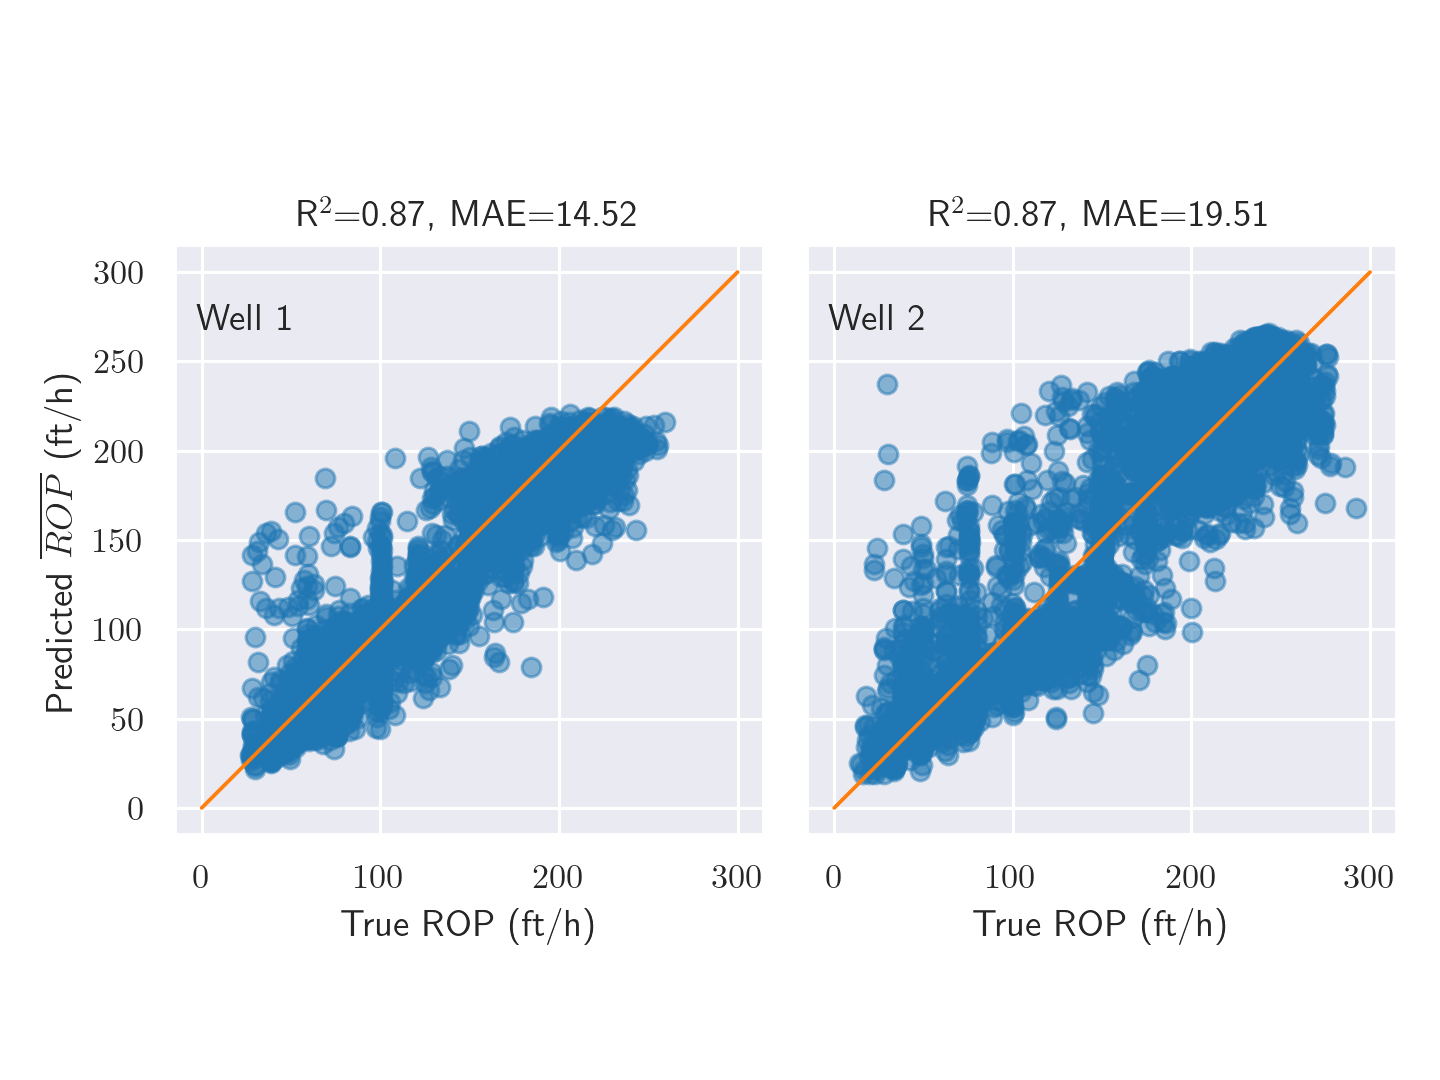

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=120)

ax[0].plot(y1, y_mean1, 'o', alpha=0.5, color='tab:blue')
ax[0].plot([0,300], [0,300], '-', linewidth=1.2, color='tab:orange')

ax[1].plot(y2, y_mean2, 'o', alpha=0.5, color='tab:blue')
ax[1].plot([0,300], [0,300], '-', linewidth=1.2, color='tab:orange')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].set_xlabel('True ROP (ft/h)')
ax[1].set_xlabel('True ROP (ft/h)')
ax[0].set_ylabel('Predicted $\overline{ROP}$ (ft/h)')

ax[0].set_title(f'R$^{2}$={R2_1:0.2f}, MAE={MAE1:0.2f}')
ax[1].set_title(f'R$^{2}$={R2_2:0.2f}, MAE={MAE2:0.2f}')

ax[0].annotate('Well 1', xy=(0, 300),  xycoords='data',
        xytext=(0.2, 0.9), textcoords='axes fraction', fontsize=12,
        horizontalalignment='right', verticalalignment='top')

ax[1].annotate('Well 2', xy=(0, 300),  xycoords='data',
        xytext=(0.2, 0.9), textcoords='axes fraction', fontsize=12,
        horizontalalignment='right', verticalalignment='top')


plt.tight_layout()
plt.show()

In [10]:
alpha=0.9
max_md = w2['Hole Depth'].max()
min_md = 9000

def _plot_rop_depth(depth, rop_true, rop_mean,rop_std, test=True):
    
        """"
        depth is the measured depth to plot the ROP values against 
        rop_true is the array of true ROP values
        rop_mean is the array of mean of ROP distributions
        rop_std is the array of standard deviations of each ROP distribution
        test is a boolean indicating whether the test data was part of this well or not 
        (use True for well 2 to plot the test section)
        """

        _, ax = plt.subplots(dpi=120, figsize=(14, 4), nrows=2)

        rop_min  = rop_mean - 2*rop_std
        rop_max = rop_mean + 2*rop_std
        
        ax[0].plot(depth, rop_true, '-', alpha=0.75, 
                        linewidth=1,  color='tab:blue', label='True ROP')
        ax[0].plot(depth, rop_mean, '-', 
                alpha=0.75, linewidth=1,  color='tab:orange', label=r'$\overline{ROP}$')
        # ax.invert_yaxis()
        
        ax[0].set_xlabel('Measured Depth (ft)', alpha=alpha, fontsize=12)
        ax[0].set_ylabel('ROP (ft/h)', alpha=alpha, fontsize=12)

        # ax.set_title(title, alpha=0.75)

        l = ax[0].legend(frameon=False, loc='upper left', fontsize=12, ncol=1)
        for text in l.get_texts():
                text.set_alpha(alpha)

        ax[0].fill_between(x=depth, y1=rop_min, y2=rop_max, 
                        color='tab:green', alpha=0.4)
        

        for text in ax[1].get_xticklabels():
                text.set_alpha(alpha)
                
        for text in ax[1].get_yticklabels():
                text.set_alpha(alpha)

        for t in ax[1].xaxis.get_ticklines():
                t.set_alpha(alpha)

        for t in ax[1].yaxis.get_ticklines():
                t.set_alpha(alpha)
                
        for spine in ['top', 'bottom', 'right', 'left']:
                ax[0].spines[spine].set_alpha(alpha)
                ax[0].spines[spine].set_linewidth(1)
                ax[1].spines[spine].set_alpha(alpha)
                ax[1].spines[spine].set_linewidth(1)

        
        if test:
                rect = Rectangle((min_md, 25), max_md-min_md, 300, linewidth=1.2, edgecolor='tab:gray', 
                        facecolor='none', alpha=alpha, linestyle='--')
                ax[0].add_patch(rect)
                ax[1].set_xlim([min_md, max_md])
                
                ax[0].annotate('Test section', xy=(max_md-2500, 300),  xycoords='data',
                        xytext=(0.8, 0.95), textcoords='axes fraction', fontsize=12,
                        horizontalalignment='right', verticalalignment='top')
                
                ax[1].annotate('Test section', xy=(max_md-200, 300),  xycoords='data',
                        xytext=(0.09, 0.95), textcoords='axes fraction', fontsize=12,
                        horizontalalignment='right', verticalalignment='top')

                ax[0].set_ylim([0,400])
                ax[1].set_ylim([0,400])

        
        elif not test:
                rect = Rectangle((8500, 25), 3000, 260, linewidth=1.2, edgecolor='tab:gray', 
                        facecolor='none', alpha=alpha, linestyle='--')
                ax[0].add_patch(rect)
                ax[1].set_xlim([8500, 11500])
                
                ax[0].set_ylim([0,350])
                ax[1].set_ylim([0,350])


        ax[1].plot(depth, rop_true, '-', alpha=0.75, 
                        linewidth=1,  color='tab:blue', label='True ROP')
        ax[1].plot(depth, rop_mean, '-', 
                alpha=0.75, linewidth=1,  color='tab:orange', label=r'$\overline{ROP}$')

        # ax.invert_yaxis()


        ax[1].set_xlabel('Measured Depth (ft)', alpha=alpha, fontsize=12)
        ax[1].set_ylabel('ROP (ft/h)', alpha=alpha, fontsize=12)

        ax[1].fill_between(x=depth, y1=rop_min, y2=rop_max, 
                        color='tab:green', alpha=0.4)
        
        ax[0].tick_params(labelsize=12)
        ax[1].tick_params(labelsize=12)
        plt.tight_layout()

        
        plt.show()


<IPython.core.display.Javascript object>


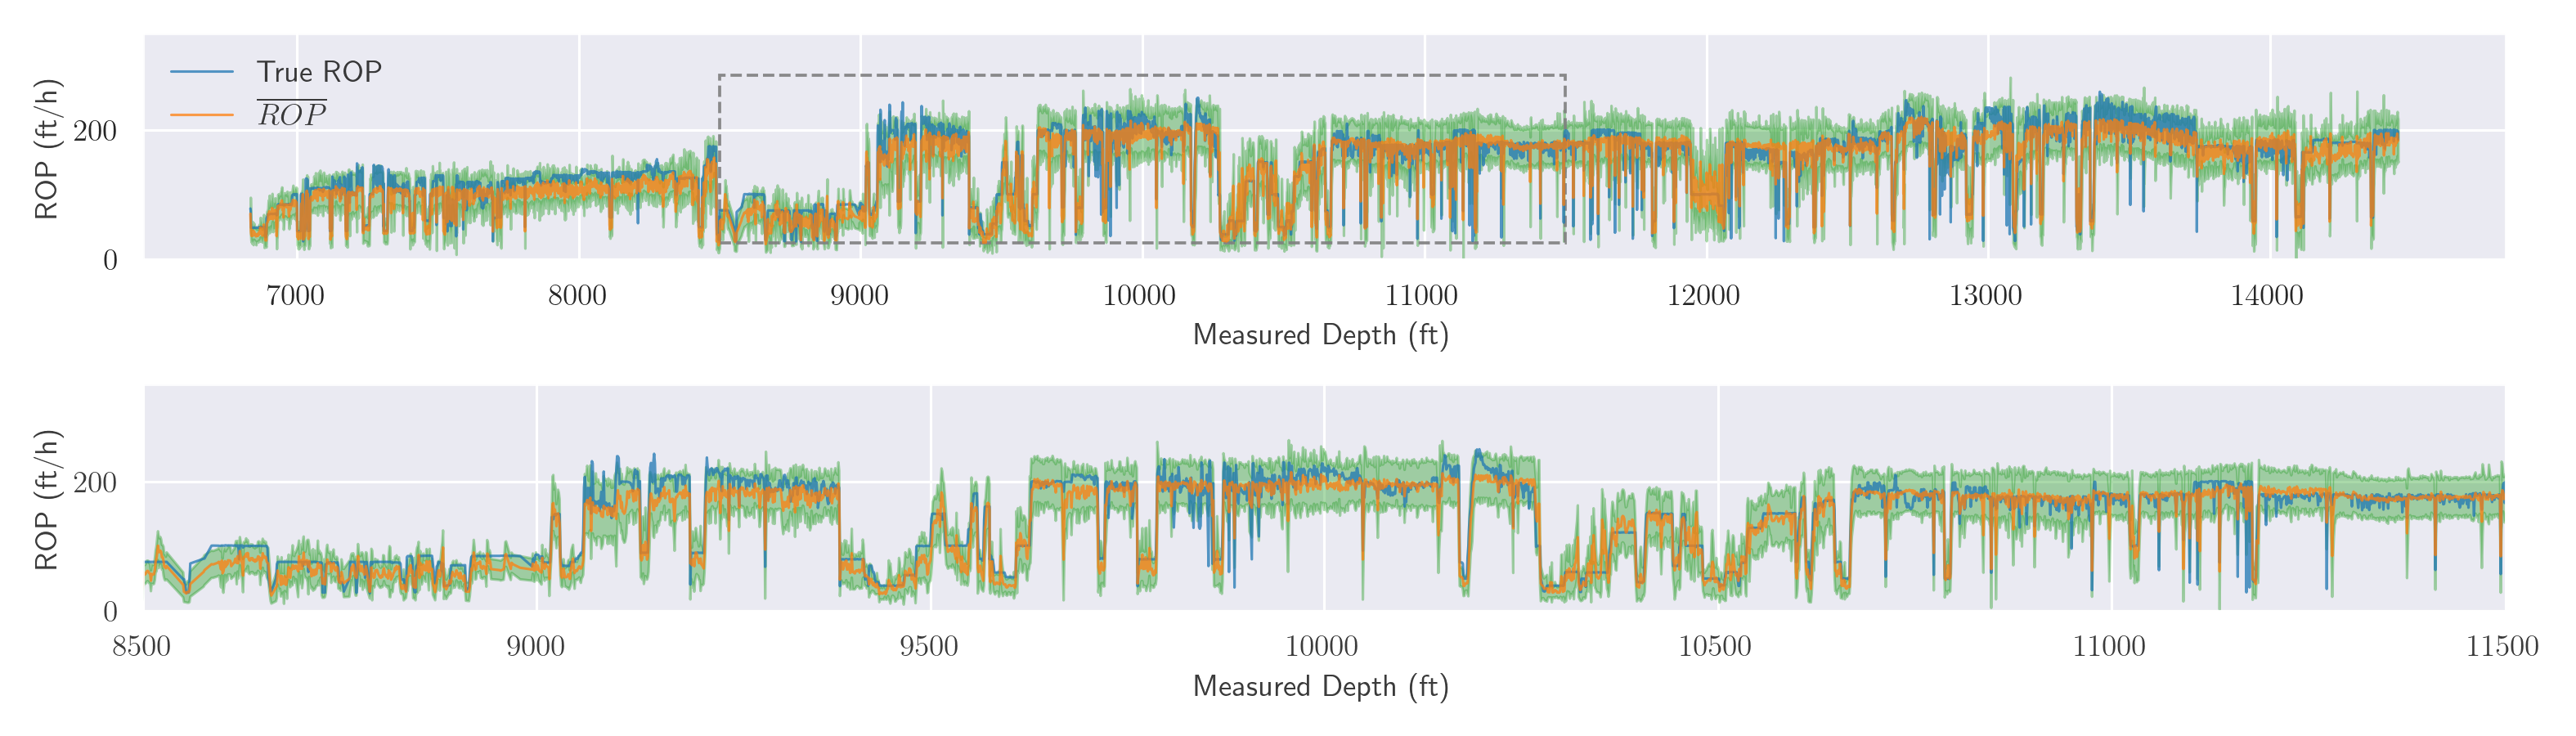

In [11]:
_plot_rop_depth(depth=w1['Hole Depth'], 
                rop_true=w1['Rate Of Penetration'], 
                rop_mean=y_mean1,
                rop_std=std_1, 
                test=False)

<IPython.core.display.Javascript object>


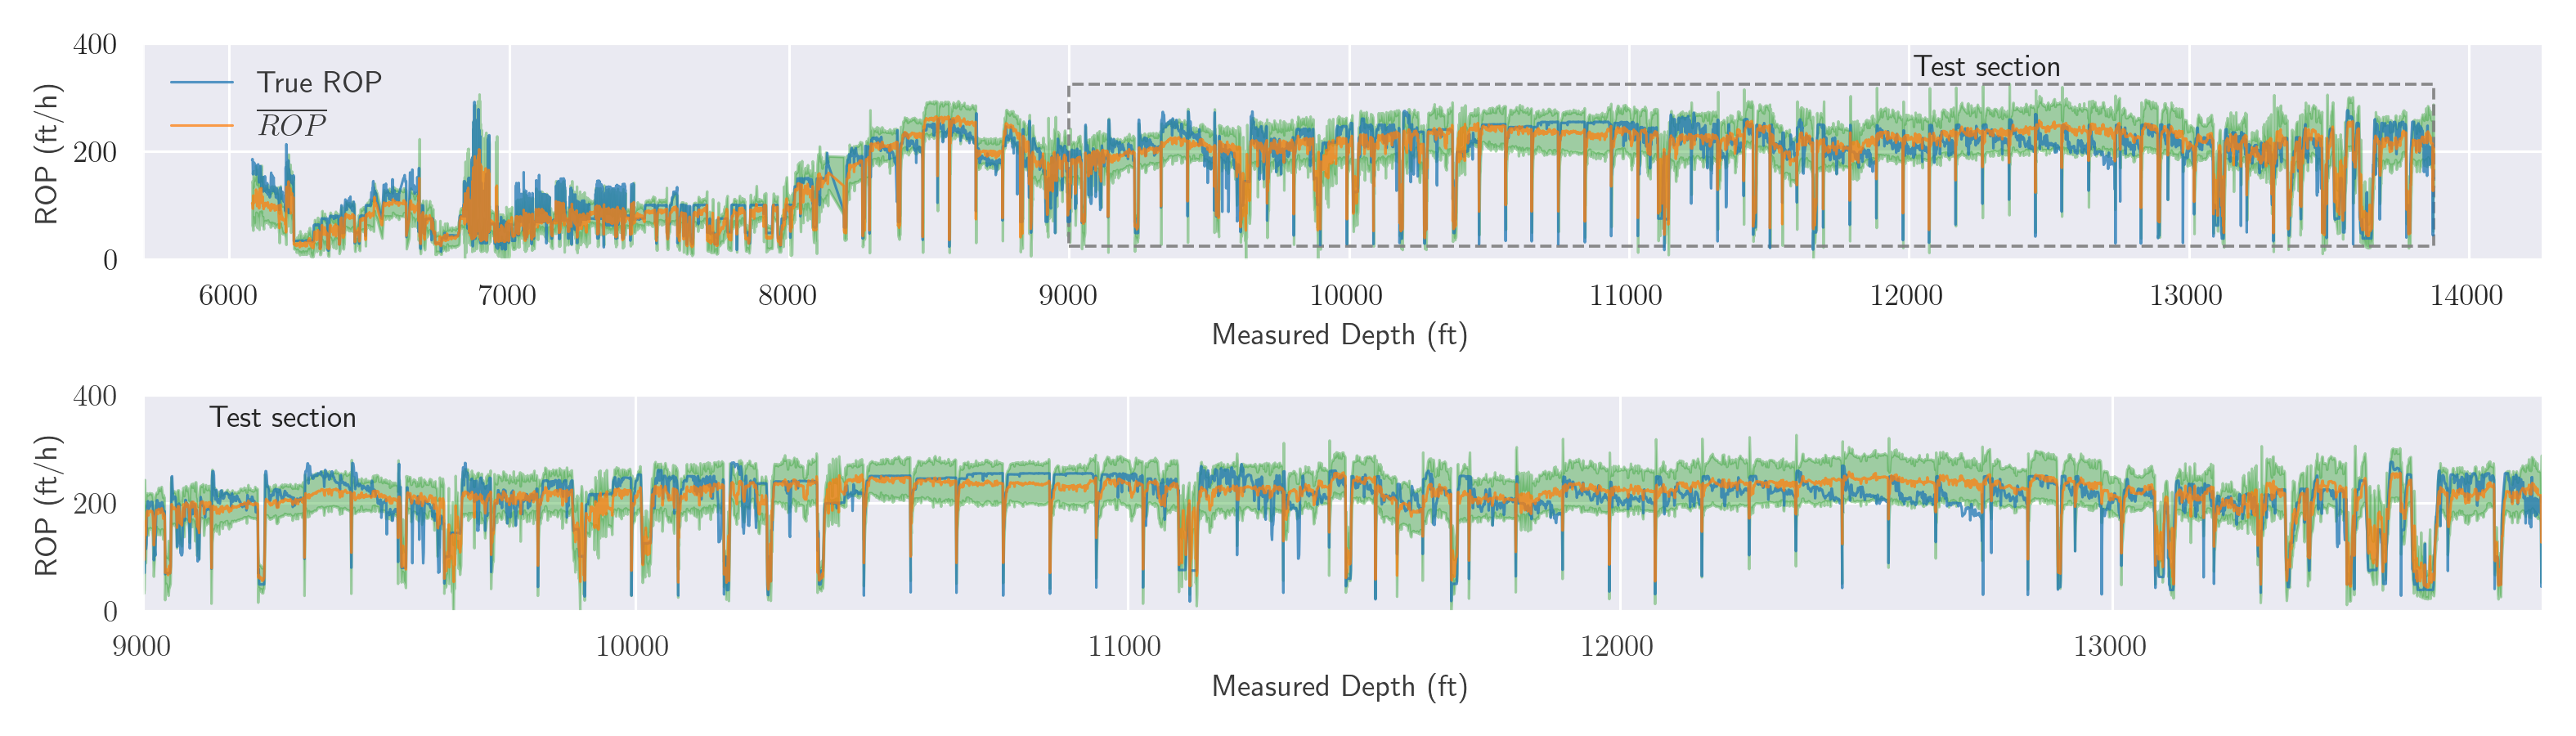

In [12]:
_plot_rop_depth(depth=w2['Hole Depth'], 
                rop_true=w2['Rate Of Penetration'], 
                rop_mean=y_mean2,
                rop_std=std_2, 
                test=True)

## Distribution of the standard deviations  

In [13]:
def _boxplot(x, ax, label, pos = [1], c1='tab:blue', c2 = 'tab:orange'):
        return ax.boxplot(x, labels=[label], 
                        positions = pos, showfliers=True,
                        patch_artist=True,
                        boxprops=dict(facecolor='w', 
                        color=c1, alpha=1),
                        capprops=dict(color=c1),
                        whiskerprops=dict(color=c1),
                        flierprops=dict(color=c1, markeredgecolor=c1, markersize=1.5),
                        medianprops=dict(color=c2, linewidth=1))


<IPython.core.display.Javascript object>


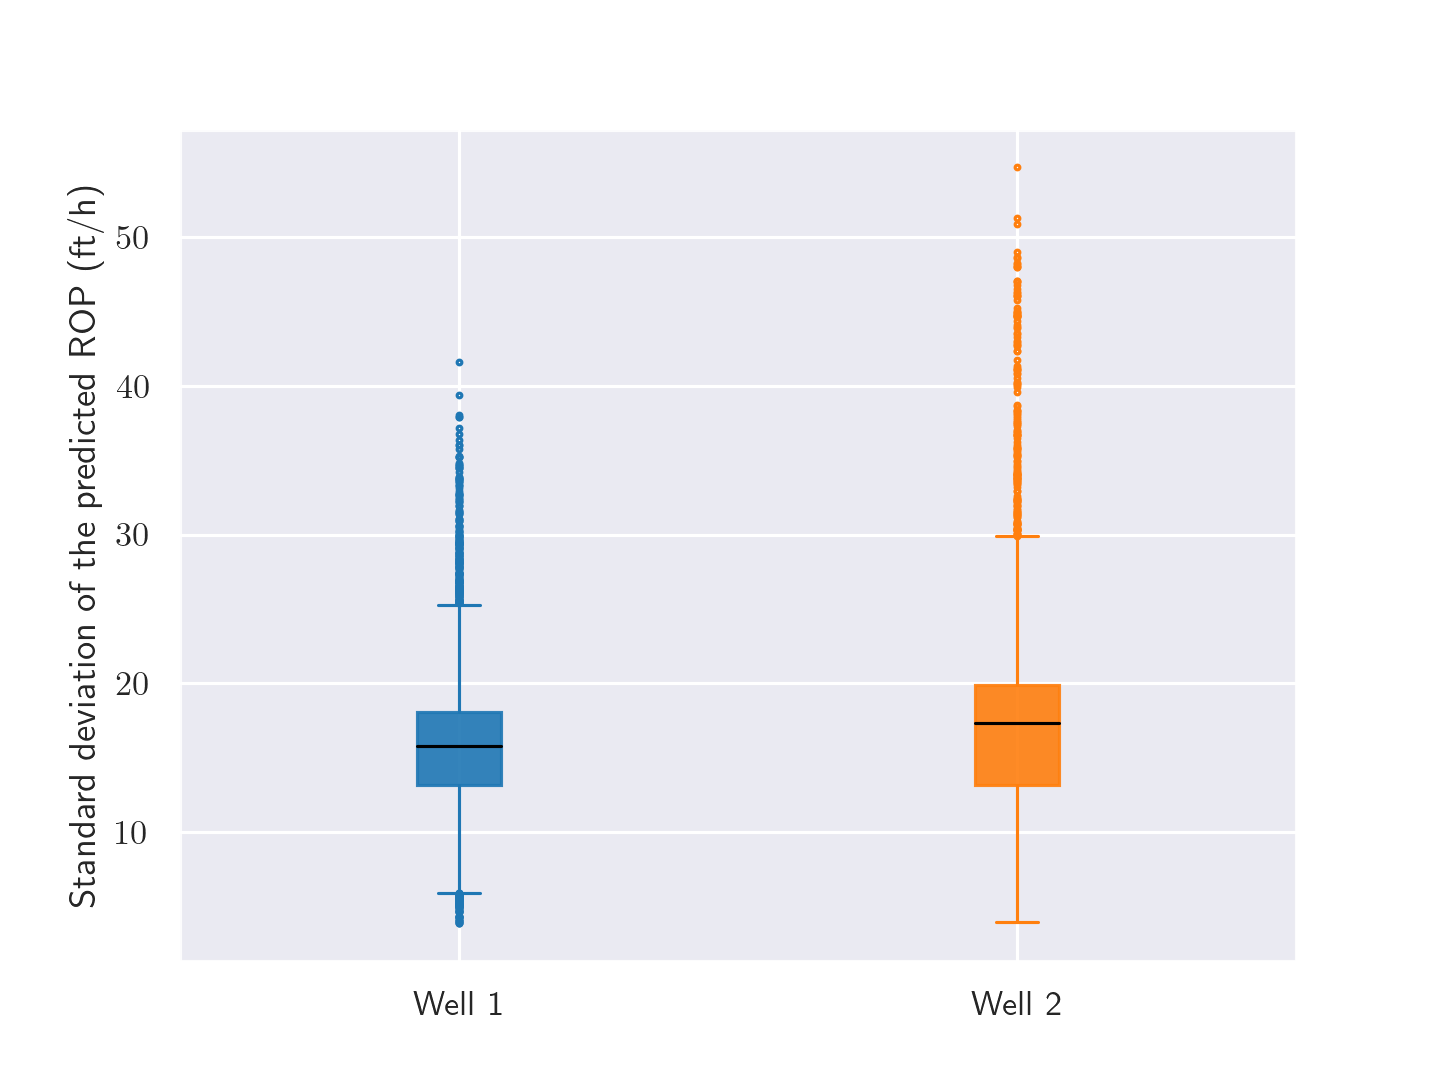

In [14]:
alpha = 0.9
fig, ax = plt.subplots(dpi=120)
# ax2 = ax.twiny()
B1 = _boxplot(std_1, ax, label = 'Well 1', pos=[1], c1='tab:blue', c2 = 'black')
B2 = _boxplot(std_2, ax, label = 'Well 2', pos=[2], c1='tab:orange', c2 = 'black')


for b1, b2 in zip(B1['boxes'], B2['boxes']):
        b1.set_facecolor('tab:blue')
        b2.set_facecolor('tab:orange')
        b1.set_alpha(0.9)
        b2.set_alpha(0.9)
        
ax.set_ylabel('Standard deviation of the predicted ROP (ft/h)')

for label in ax.get_xticklabels():
        label.set_ha("center")
        label.set_rotation(0)

ax.tick_params(axis='x', which='minor', bottom=False, top = False)
ax.tick_params(axis='x', which='major', bottom=False, top = False)

for spine in ['top', 'bottom', 'right', 'left']:
        ax.spines[spine].set_alpha(alpha)
        ax.spines[spine].set_linewidth(1)


plt.show()


<IPython.core.display.Javascript object>


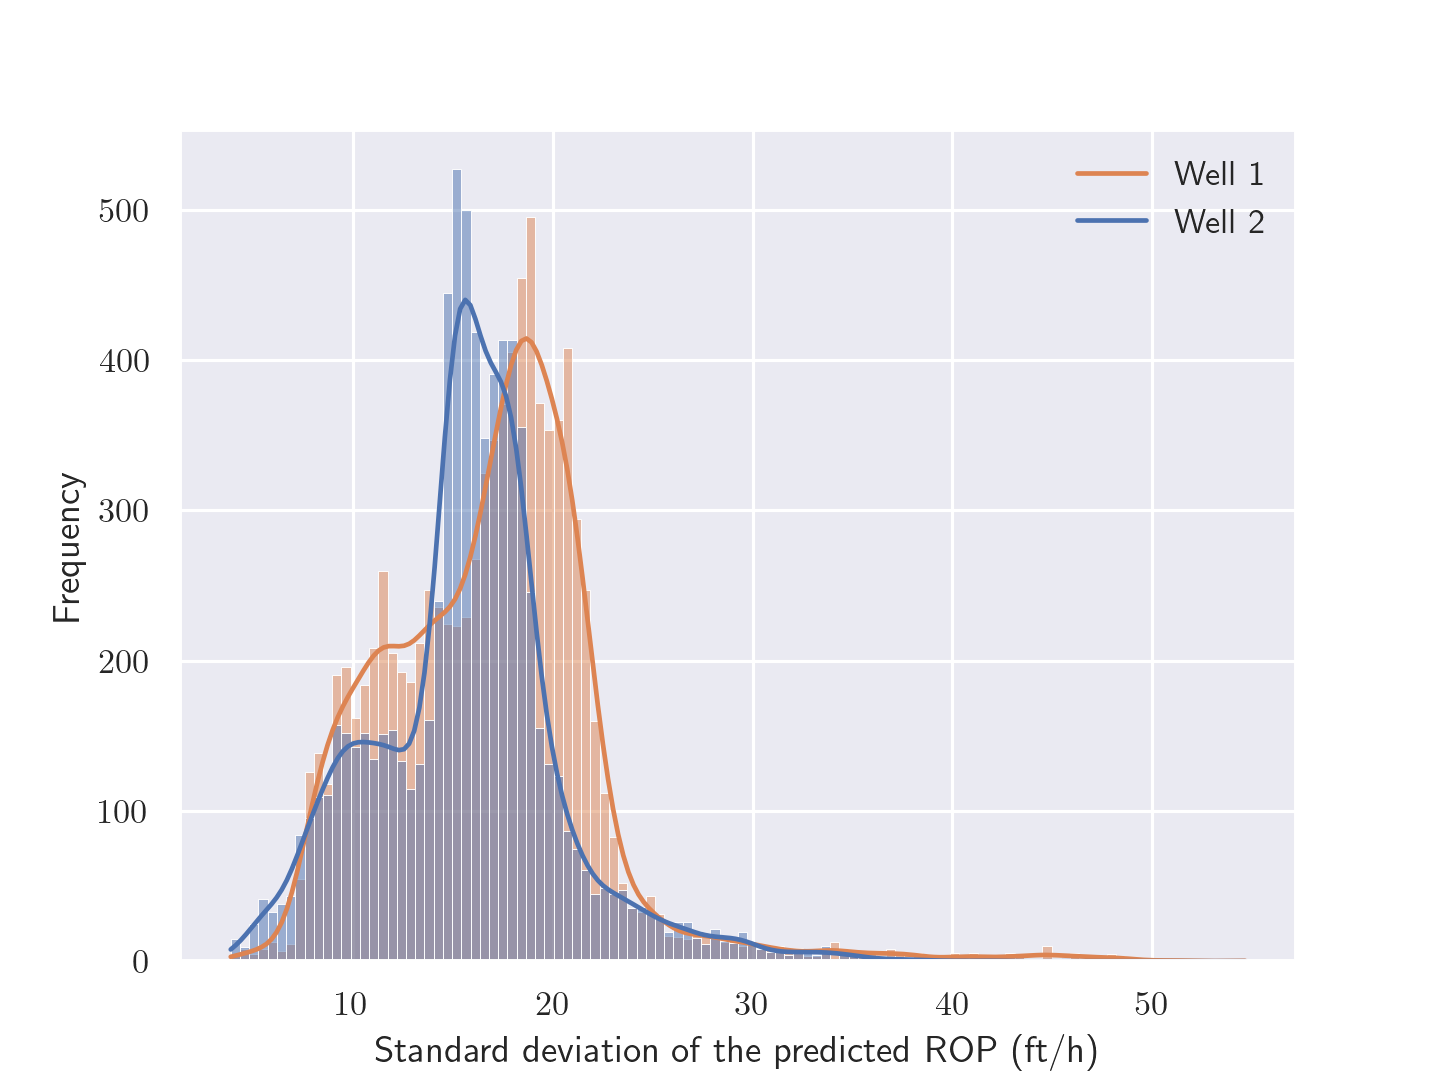

In [15]:
fig, ax  = plt.subplots(dpi=120)

sns.histplot([std_1, std_2], stat='frequency', kde=True, ax=ax)

ax.legend(['Well 1', 'Well 2'], frameon=False, loc='upper right')
ax.set_xlabel('Standard deviation of the predicted ROP (ft/h)')

plt.show()

## Sample ROP distribution

<IPython.core.display.Javascript object>


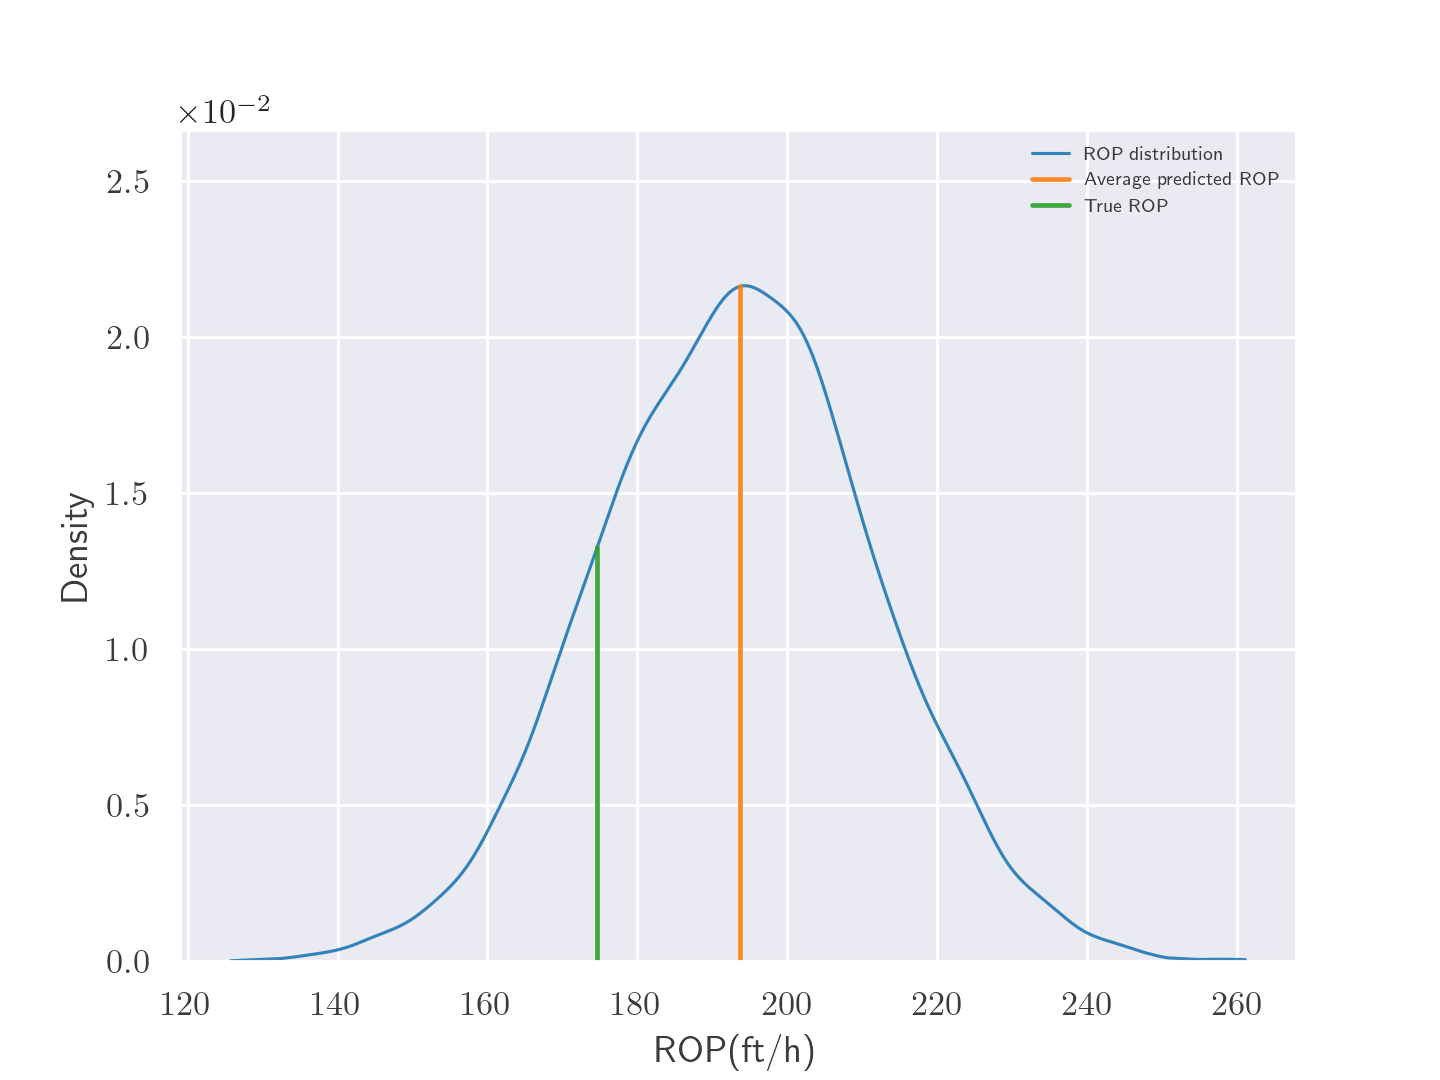

In [17]:
alpha = 0.9

n = np.random.choice(X1.shape[0])
dist = np.random.normal(loc=y_mean1[n], 
                        scale=std_1[n], size=10000)


dist = np.sort(dist)
kde = stats.gaussian_kde(dist)
density = kde(dist)

idx1 = np.argmin(np.abs(y_mean1[n] - dist))
idx2 = np.argmin(np.abs(y1[n] - dist))


fig, ax  = plt.subplots(dpi=120)

ax.plot(dist, density, color='tab:blue', linewidth=1, alpha=alpha, 
        label='ROP distribution')

ax.plot([y_mean1[n], y_mean1[n]], 
        [0, density[idx1]], color='tab:orange',alpha=alpha, label='Average predicted ROP')

ax.plot([y1[n], y1[n]], 
        [0, density[idx2]], color='tab:green',alpha=alpha, label='True ROP')


ax.legend()

ax.set_xlabel('ROP(ft/h)', alpha=alpha)
ax.set_ylabel('Density', alpha=alpha)


l = ax.legend(frameon=False, loc='upper right', fontsize=6, ncol=1)
for text in l.get_texts():
        text.set_alpha(alpha)

for text in ax.get_xticklabels():
        text.set_alpha(alpha)
        
for text in ax.get_yticklabels():
        text.set_alpha(alpha)

for t in ax.xaxis.get_ticklines():
        t.set_alpha(alpha)

for t in ax.yaxis.get_ticklines():
        t.set_alpha(alpha)
        
for spine in ['top', 'bottom', 'right', 'left']:
        ax.spines[spine].set_alpha(alpha)
        ax.spines[spine].set_linewidth(1)


ax.set_ylim([0, np.max(density)+0.005])

ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0),
                useOffset=None, useLocale=None, useMathText=True)

plt.show()
